# Group Level Network Analysis

In [1]:
ds = '36p' # Denoising Strategy:
# It could be '9p', 'r36p' or '36pscrubbed'
ct = 'pearson' #Correlation Type
tm = 'gce' # Thresholding Method:
           # It could be 'GCE' or 'user_defined'
tv = 0.05  # Thresholding Value

### Import

In [2]:
from config import *
from src.data import subjects
import src.group_level_analysis.group_level_analysis as gla
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from IPython.display import display
import seaborn as sns
from random import randint
import hoggorm as ho
import networkx as nx
from skbio.stats.distance import mantel

### Read Data

In [3]:
all_sub_list = subjects.to_group_level_analysis[0]
all_subjects = subjects.subjects['all'][subjects.subjects['all']['participant_id'].isin(all_sub_list)]

subjects_list = {}
for sg in subjects_groups:
    subjects_list[sg] = all_subjects.where(all_subjects.group==sg).dropna()
    print('\n%d %s subjects are included'%(len(subjects_list[sg]),sg))
    display(subjects_list[sg])
    subjects_list[sg] = subjects_list[sg].participant_id.tolist()


24 CN subjects are included


,group,participant_id,sex,age
0,CN,003S4288,F,78.4
1,CN,011S0021,F,84.9
2,CN,020S6185,M,82.7
3,CN,023S1190,F,87.4
4,CN,035S6160,M,60.7
5,CN,036S6189,F,69.6
6,CN,037S4028,F,70.7
7,CN,041S4200,F,76.4
8,CN,041S6159,M,76.3
9,CN,041S6192,F,83.3



16 EMCI subjects are included


,group,participant_id,sex,age
24,EMCI,012S4987,M,69.0
25,EMCI,002S4473,M,79.9
26,EMCI,011S4547,M,82.8
27,EMCI,011S4893,F,73.4
28,EMCI,012S4188,M,83.2
30,EMCI,037S4706,M,66.2
31,EMCI,041S4513,M,66.4
32,EMCI,041S4974,M,78.4
37,EMCI,068S2184,F,87.4
38,EMCI,068S2315,F,74.9



23 LMCI subjects are included


,group,participant_id,sex,age
48,LMCI,002S4171,M,69.0
49,LMCI,002S4219,F,80.0
50,LMCI,002S4229,M,66.0
51,LMCI,002S4251,M,72.0
52,LMCI,002S4654,F,75.0
53,LMCI,002S4746,F,72.0
55,LMCI,006S4346,M,71.0
56,LMCI,006S4363,F,74.0
57,LMCI,006S4515,M,75.0
58,LMCI,006S4713,M,71.0



24 AD subjects are included


,group,participant_id,sex,age
72,AD,002S5018,M,73.4
73,AD,006S4153,M,81.5
74,AD,006S4867,M,75.7
75,AD,013S5071,M,76.4
76,AD,018S4696,F,73.3
77,AD,018S4733,M,75.4
78,AD,018S5074,F,74.9
79,AD,019S4252,F,86.8
80,AD,019S4477,F,82.4
81,AD,019S4549,M,79.4


In [4]:
str_loc    = ['loc_'  + ds for ds in denoising_strategies]
str_glob   = ['glob_' + ds for ds in denoising_strategies]
strlist    = str_loc.copy()
strlist.extend(str_glob)

In [5]:
if tm=='userdefined':
    tm = '%s-%.3f'%(tm,tv)

In [6]:
norm = ""
if normalize_measures:
    norm="_norm"

directoies = {}
for ds in denoising_strategies:
    dirc = '%s/data/06_network_measures/tm-%s/corr-%s/ds-%s/'%(rootdir,tm,ct,ds)

    lc  = 'loc_'  + ds
    glb = 'glob_' + ds
    directoies[glb]    = glob.glob("%s/*/*global_measures_giant_component.csv"%(dirc))
    directoies[lc] = glob.glob("%s/*/*local_measures_giant_component*%s*.csv"%(dirc,norm))

In [7]:
measures = {}
measures['all'] = {}

for sg in subjects_groups: 
    measures[sg]  = {}

for i in strlist:
    measures['all'][str(i)] = {}
    for sg in subjects_groups: 
        measures[sg][str(i)]  = {}
    for sub in directoies[str(i)]:
        id = str(sub.split("/sub-")[1].split('/sub-')[0]) 
        measures['all'][str(i)][id]    = pd.read_csv(sub, sep='\t')
        measures['all'][str(i)][id]    = measures['all'][str(i)][id].drop(['Unnamed: 0'], axis=1)
        
        for sg in subjects_groups: 

            if id in subjects_list[sg]:
                measures[sg][str(i)][id] = pd.read_csv(sub, sep='\t')
                measures[sg][str(i)][id] = measures[sg][str(i)][id].drop(['Unnamed: 0'], axis=1)

In [8]:
# measures variable structure:
#
#    measures
#    │
#    ├── group 1
#    │   ├── denoising strategie 1- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 1- local measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 2- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 2- local measures
#    │   │   └── group 1 subjects
#    │   ├── ...
#    │   │
#    │   └── denoising strategie n- local measures
#    │       └── group 1 subjects
#    │   
#    ├── ...
#    │
#    └── last group
#        ├── denoising strategie 1- global measures
#        │   └── last group subjects
#        ├── denoising strategie 1- local measures
#        │   └── last group subjects
#        ├── denoising strategie 2- global measures
#        │   └── last group subjects
#        ├── denoising strategie 2- local measures
#        │   └── last group subjects
#        ├── ...
#        │
#        └── denoising strategie n- local measures
#            └── last group subject

In [9]:
#pd.DataFrame.from_dict(all_measures).to_csv('/home/alireza/out.csv',index=False)
measures['all']['loc_9p']['020S6185']

,ID,degree,eccentricity,betweenness,com_betweenness,eigenvector,katz,closeness,current_flow_closeness,load,clustering_coef,pagerank,subgraph,harmonic,strength
0,0,0.234043,1.0,0.001819,0.094718,0.256782,0.300785,0.184291,0.442107,0.001695,0.968204,0.215213,0.071587,0.237253,0.087294
1,1,0.797872,0.0,0.219811,0.719182,0.799285,0.480257,0.741497,0.909304,0.214389,0.424032,0.756957,0.643608,0.816857,0.645825
2,2,0.776596,1.0,0.124579,0.803127,0.866212,0.566992,0.513035,0.896010,0.129831,0.486568,0.723400,0.753772,0.678460,0.630999
3,3,0.755319,0.0,0.112491,0.698144,0.791962,0.449972,0.513035,0.883994,0.109255,0.486179,0.716895,0.632103,0.669095,0.488022
4,4,0.840426,0.0,0.153224,0.810599,0.871143,0.489170,0.653563,0.926364,0.148306,0.473399,0.799344,0.762239,0.785640,0.616029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,355,0.659574,0.0,0.516777,0.180513,0.305074,0.232328,0.801962,0.836903,0.490725,0.233208,0.688327,0.099304,0.793965,0.581823
355,356,0.297872,0.0,0.087487,0.034795,0.115276,0.215680,0.426084,0.526096,0.098828,0.260836,0.316606,0.016297,0.433923,0.346010
356,357,0.797872,0.0,0.306509,0.367630,0.472250,0.455519,0.822698,0.913885,0.301615,0.287041,0.809618,0.230289,0.858481,0.825761
357,358,0.585106,0.0,0.186424,0.148393,0.262061,0.568203,0.698745,0.786834,0.211435,0.257688,0.603347,0.074358,0.710718,0.600505


In [10]:
print('the number of nodes appeared in the giant components of all subjects:\n') 
intersect = {}
for i in str_loc:
    intersect[i] = list(range(360))
for i in str_loc:
    for sub in measures['all'][i]:
        a = measures['all'][i][sub].ID.to_list()
        intersect[i] = list(set(intersect[i]) & set(a))
    name = i.split('loc_')[1]
    print('\t%d out of 360 nodes for networks with %s thresholding method.'
          %(len(intersect[i]),name))

    #removing nodes
    for sub in measures['all'][i]:
        measures['all'][str(i)][sub] = measures['all'][str(i)][sub].loc[measures['all'][str(i)][sub]['ID'].isin(intersect[i])]

the number of nodes appeared in the giant components of all subjects:

	355 out of 360 nodes for networks with 9p thresholding method.
	359 out of 360 nodes for networks with 36p thresholding method.
	359 out of 360 nodes for networks with 36pscrubbed thresholding method.


### local measures mean and variance

In [11]:
# the mvfunc output structure:
#   
#         mvfunc(measures, sub_list, str_list)
#         │  
#         ├── mean
#         │   ├── denoising strategie 2- global measures
#         │   │   └─── subjects
#         │   ├── denoising strategie 1- local measures
#         │   │   └─── subjects
#         │   ├── denoising strategie 2- global measures
#         │   │   └─── subjects
#         │   ├── denoising strategie 2- local measures
#         │   │   └─── subjects
#         │   ├── ...
#         │   │
#         │   ├── denoising strategie n- global measures
#         │   │   └─── subjects
#         │   └── denoising strategie n- local measures
#         │       └─── subjects
#         └── var
#             ├── denoising strategie 2- global measures
#             │   └─── subjects
#             ├── denoising strategie 1- local measures
#             │   └─── subjects
#             ├── denoising strategie 2- global measures
#             │   └─── subjects
#             ├── denoising strategie 2- local measures
#             │   └─── subjects
#             ├── ...
#             │
#             ├── denoising strategie n- global measures
#             │   └─── subjects
#             └── denoising strategie n- local measures
#                 └─── subjects

In [12]:
gla.mvfunc(measures['CN'],subjects_list['CN'], strlist)['mean']['loc_36p']

,003S4288,011S0021,020S6185,023S1190,035S6160,036S6189,037S4028,041S4200,041S6159,041S6192,...,168S6098,168S6085,168S6131,941S6094,116S4453,033S4176,002S4262,002S4225,031S4032,018S4313
degree,0.563283,0.522495,0.580258,0.606192,0.436295,0.476699,0.503392,0.430362,0.433983,0.465634,...,0.426748,0.423255,0.520154,0.457705,0.483770,0.450798,0.439521,0.461308,0.509932,0.540512
eccentricity,0.512535,0.008357,0.038997,0.568245,0.161560,0.027855,0.381616,0.142061,0.013928,0.000000,...,0.050139,0.325905,0.016713,0.000000,0.000000,0.000000,0.139276,0.005571,0.058496,0.005571
betweenness,0.209345,0.283799,0.173776,0.181920,0.271118,0.206599,0.256999,0.204495,0.242819,0.285404,...,0.173219,0.117449,0.216088,0.295769,0.262104,0.214667,0.236803,0.264059,0.289594,0.322006
com_betweenness,0.470151,0.286990,0.392751,0.330906,0.254559,0.257132,0.242620,0.233388,0.230846,0.271684,...,0.258769,0.246450,0.291180,0.251165,0.275190,0.246960,0.229013,0.274925,0.317026,0.301713
eigenvector,0.421939,0.404735,0.510421,0.371404,0.340032,0.353055,0.327992,0.320311,0.317114,0.360358,...,0.333579,0.311660,0.383515,0.365139,0.376049,0.340526,0.302605,0.386522,0.441428,0.419096
katz,0.365855,0.507520,0.510386,0.472191,0.502580,0.535608,0.546500,0.432951,0.595270,0.439680,...,0.594814,0.484168,0.450171,0.398168,0.460865,0.481735,0.542012,0.514175,0.509132,0.595310
closeness,0.638551,0.641685,0.612395,0.585957,0.561276,0.578408,0.702936,0.561637,0.565585,0.592490,...,0.586243,0.596774,0.607478,0.610136,0.520292,0.509965,0.603922,0.577643,0.623549,0.641930
current_flow_closeness,0.738131,0.726798,0.729125,0.768537,0.666411,0.647828,0.757443,0.712612,0.657839,0.678463,...,0.699861,0.725535,0.689932,0.679648,0.660786,0.649184,0.687624,0.661846,0.713381,0.735543
load,0.208487,0.286455,0.186521,0.165172,0.278096,0.212522,0.265928,0.210616,0.247974,0.282969,...,0.175207,0.126470,0.210924,0.298927,0.273991,0.216979,0.241710,0.253784,0.296017,0.336960
clustering_coef,0.470504,0.453996,0.364974,0.509613,0.387896,0.397640,0.657945,0.611066,0.334170,0.430241,...,0.533603,0.666891,0.453758,0.369140,0.347877,0.461875,0.353093,0.528676,0.572593,0.458899


In [13]:
groups = ['all','CN','EMCI','LMCI','AD']
gla.mvfunc_total(measures,groups,strlist,'36p')

,all_mean,all_var,CN_mean,CN_var,EMCI_mean,EMCI_var,LMCI_mean,LMCI_var,AD_mean,AD_var
degree,0.479725,0.048180,0.479304,0.044584,0.471721,0.047638,0.488997,0.050367,0.476598,0.049922
eccentricity,0.156053,0.123476,0.127205,0.111037,0.113684,0.100777,0.163982,0.119848,0.205548,0.150026
betweenness,0.238998,0.029167,0.232362,0.029000,0.234823,0.027467,0.230601,0.028501,0.256464,0.030687
com_betweenness,0.272910,0.076894,0.278385,0.073510,0.267791,0.078374,0.273139,0.078712,0.270629,0.077523
eigenvector,0.358270,0.075514,0.363258,0.071344,0.355253,0.077356,0.358862,0.077867,0.354725,0.076184
katz,0.487352,0.030048,0.495779,0.030441,0.491048,0.030121,0.475844,0.028405,0.487492,0.030986
closeness,0.609774,0.033019,0.588877,0.033741,0.599729,0.035563,0.628217,0.031535,0.619693,0.031106
current_flow_closeness,0.706731,0.037194,0.695052,0.036201,0.697578,0.037316,0.717517,0.037812,0.714175,0.037166
load,0.243807,0.028736,0.236501,0.028644,0.240791,0.027323,0.233213,0.027708,0.263276,0.030219
clustering_coef,0.498070,0.036291,0.472147,0.037970,0.490116,0.033140,0.528070,0.034613,0.500545,0.036750


### Correlation between centraliry measures

In [14]:
mes_rel = gla.mes_rel(measures,groups,strlist,'36p')

In [15]:
mes_rel['corr']['loc_36p']['all']

,degree,eccentricity,betweenness,com_betweenness,eigenvector,katz,closeness,current_flow_closeness,load,clustering_coef,pagerank,subgraph,harmonic,strength
degree,1.000000,0.075030,0.006778,0.712209,0.704124,-0.156282,0.566947,0.734231,0.000459,0.144919,0.940180,0.726667,0.743569,-0.118415
eccentricity,0.075030,1.000000,-0.420501,0.181641,-0.129156,-0.088326,0.281072,0.412011,-0.413882,0.321219,0.168031,0.150556,0.273869,0.228873
betweenness,0.006778,-0.420501,1.000000,-0.166080,0.135182,0.138127,0.180042,-0.061704,0.991783,-0.139527,-0.020584,-0.179266,0.086535,0.009253
com_betweenness,0.712209,0.181641,-0.166080,1.000000,0.788713,-0.150238,0.356091,0.552010,-0.174915,0.215701,0.626909,0.955808,0.489092,-0.077637
eigenvector,0.704124,-0.129156,0.135182,0.788713,1.000000,-0.048278,0.421905,0.466793,0.139212,0.100632,0.554967,0.796361,0.535047,-0.024872
katz,-0.156282,-0.088326,0.138127,-0.150238,-0.048278,1.000000,-0.020472,0.008674,0.142219,0.056563,-0.139068,-0.102535,-0.062747,0.045564
closeness,0.566947,0.281072,0.180042,0.356091,0.421905,-0.020472,1.000000,0.763887,0.193257,0.421066,0.568118,0.322353,0.942998,0.130741
current_flow_closeness,0.734231,0.412011,-0.061704,0.552010,0.466793,0.008674,0.763887,1.000000,-0.054358,0.504068,0.787933,0.543202,0.833224,0.073970
load,0.000459,-0.413882,0.991783,-0.174915,0.139212,0.142219,0.193257,-0.054358,1.000000,-0.149392,-0.033101,-0.195302,0.097704,0.013348
clustering_coef,0.144919,0.321219,-0.139527,0.215701,0.100632,0.056563,0.421066,0.504068,-0.149392,1.000000,0.214418,0.194228,0.349200,0.090474


In [15]:
sg = subjects_groups.copy()
sg.append('all')
sg

['CN', 'EMCI', 'LMCI', 'AD', 'all']

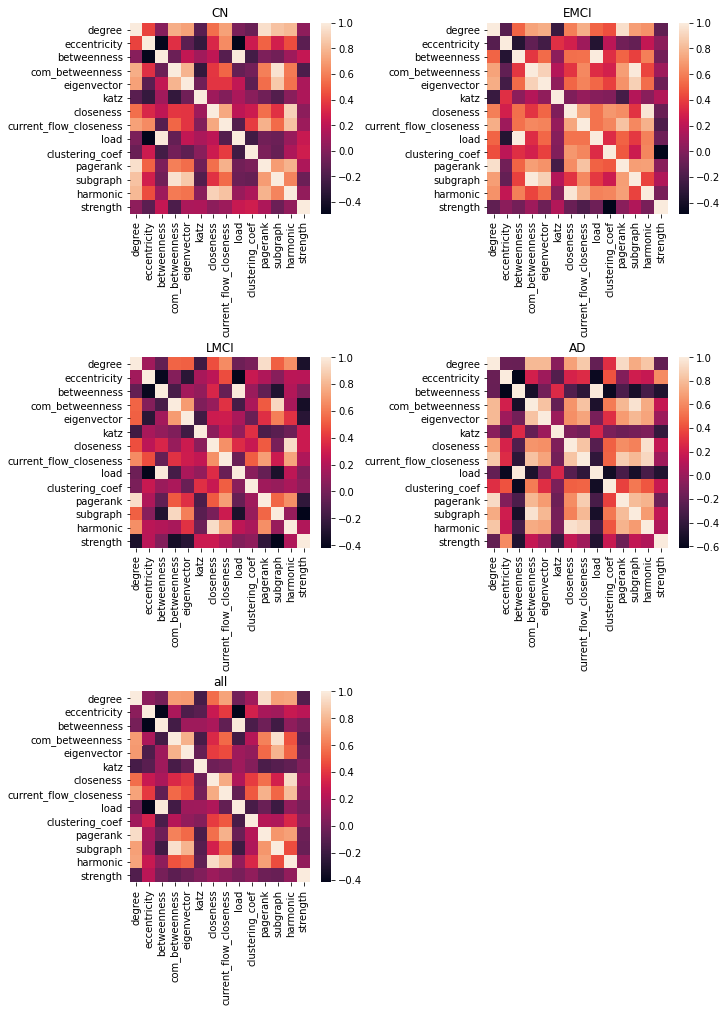

In [17]:
ff = plt.figure(figsize=(10,14))
ax=[]
g =[]
for i in range(len(sg)):
    ax.append(ff.add_subplot((len(sg)+1)//2,2,i+1))
for i in range(len(sg)):
    g.append(sns.heatmap(mes_rel['corr']['loc_36p'][sg[i]],ax=ax[i]))

    ax[i].title.set_text(sg[i])
plt.tight_layout(pad=.5)

### Correlation between subjects
list of subjects sorted based on their group:

In [9]:
cols = subjects_list[subjects_groups[0]].copy()
sep=[len(subjects_list[subjects_groups[0]])]
for i in range(1,len(subjects_groups)):
    cols.extend(subjects_list[subjects_groups[i]])
    sep.append(len(subjects_list[subjects_groups[i]]) + sep[i-1])
sep.insert(0,0)

#### correlation based on centrality measures

In [19]:
sub_rel = gla.sub_rel(measures,groups,strlist,'36p')

In [20]:
display( sub_rel['cov']['loc_36p']['all'],
         sub_rel['cov']['loc_36p']['AD' ],
         sub_rel['cov']['loc_36p']['CN' ])

,036S4715,020S6185,019S4549,136S4993,130S4971,068S4061,041S4974,130S4730,006S4153,130S5231,...,037S4214,035S4414,041S4513,006S4515,018S4733,002S4654,941S4187,168S6131,130S4990,013S4395
036S4715,0.031079,0.032926,0.032185,0.022913,0.005869,0.032553,0.031535,0.034648,0.032274,0.029001,...,0.025870,0.032128,0.029498,0.031391,0.032593,0.032323,0.025982,0.032693,0.028881,0.029977
020S6185,0.032926,0.041654,0.035802,0.024309,0.005701,0.037266,0.033173,0.037273,0.033778,0.034714,...,0.029970,0.035867,0.030815,0.033732,0.033001,0.033749,0.029159,0.037587,0.036068,0.030916
019S4549,0.032185,0.035802,0.034246,0.023494,0.005653,0.034502,0.033273,0.036113,0.033620,0.031629,...,0.027454,0.034161,0.030721,0.033263,0.034149,0.033782,0.027491,0.035100,0.031717,0.031768
136S4993,0.022913,0.024309,0.023494,0.037023,0.033967,0.031328,0.026512,0.026702,0.023254,0.032857,...,0.036842,0.027229,0.025459,0.031969,0.025392,0.024512,0.034250,0.026845,0.036851,0.027913
130S4971,0.005869,0.005701,0.005653,0.033967,0.049364,0.018013,0.010431,0.008314,0.005579,0.021203,...,0.030065,0.009109,0.011907,0.018935,0.008326,0.005971,0.027196,0.008627,0.025945,0.014230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002S4654,0.032323,0.033749,0.033782,0.024512,0.005971,0.033921,0.033732,0.036105,0.033693,0.031145,...,0.028023,0.034336,0.031001,0.033999,0.034947,0.034570,0.027846,0.034811,0.031599,0.032721
941S4187,0.025982,0.029159,0.027491,0.034250,0.027196,0.033594,0.029071,0.030185,0.026417,0.034124,...,0.036194,0.029839,0.027741,0.033757,0.028504,0.027846,0.034191,0.030549,0.037655,0.030374
168S6131,0.032693,0.037587,0.035100,0.026845,0.008627,0.036353,0.034428,0.036985,0.033884,0.034891,...,0.031386,0.036194,0.031499,0.035433,0.034793,0.034811,0.030549,0.037130,0.036336,0.033309
130S4990,0.028881,0.036068,0.031717,0.036851,0.025945,0.038458,0.033002,0.033638,0.029340,0.040535,...,0.040982,0.035769,0.030140,0.038476,0.031630,0.031599,0.037655,0.036336,0.046286,0.033929


,019S4549,136S4993,130S4971,130S4730,006S4153,130S5231,130S4641,100S5106,018S5074,013S5071,...,053S5208,019S5012,130S5059,006S4867,130S4589,053S5070,130S4660,019S4477,018S4733,130S4990
019S4549,0.034246,0.023494,0.005653,0.036113,0.033620,0.031629,0.030665,0.031142,0.032993,0.029094,...,0.033745,0.021182,0.030598,0.031687,0.033052,0.034140,0.026963,0.020067,0.034149,0.031717
136S4993,0.023494,0.037023,0.033967,0.026702,0.023254,0.032857,0.030175,0.023881,0.029088,0.031928,...,0.025759,0.030744,0.023144,0.027151,0.027954,0.025910,0.031943,0.030655,0.025392,0.036851
130S4971,0.005653,0.033967,0.049364,0.008314,0.005579,0.021203,0.017457,0.008918,0.014745,0.023230,...,0.006964,0.028224,0.006637,0.011955,0.012308,0.007644,0.024769,0.029435,0.008326,0.025945
130S4730,0.036113,0.026702,0.008314,0.038962,0.035888,0.033577,0.033037,0.033964,0.035437,0.031027,...,0.036329,0.024106,0.032678,0.034413,0.035709,0.037163,0.028726,0.023306,0.036625,0.033638
006S4153,0.033620,0.023254,0.005579,0.035888,0.033937,0.030104,0.030001,0.031833,0.032619,0.027524,...,0.033835,0.020970,0.031201,0.031909,0.032790,0.034516,0.025077,0.020389,0.034323,0.029340
130S5231,0.031629,0.032857,0.021203,0.033577,0.030104,0.037765,0.033441,0.028159,0.033975,0.035262,...,0.031680,0.027359,0.028487,0.031092,0.032560,0.030962,0.033974,0.026380,0.031768,0.040535
130S4641,0.030665,0.030175,0.017457,0.033037,0.030001,0.033441,0.032337,0.028825,0.032834,0.032044,...,0.031462,0.025357,0.029092,0.031176,0.031715,0.031574,0.030345,0.024386,0.031862,0.035405
100S5106,0.031142,0.023881,0.008918,0.033964,0.031833,0.028159,0.028825,0.030743,0.031221,0.026571,...,0.031838,0.021510,0.029544,0.030722,0.031072,0.032794,0.024086,0.021341,0.032682,0.027478
018S5074,0.032993,0.029088,0.014745,0.035437,0.032619,0.033975,0.032834,0.031221,0.034885,0.033120,...,0.033716,0.024353,0.031538,0.032894,0.032611,0.032673,0.030316,0.023783,0.034890,0.035151
013S5071,0.029094,0.031928,0.023230,0.031027,0.027524,0.035262,0.032044,0.026571,0.033120,0.035694,...,0.029238,0.025737,0.027351,0.029630,0.029162,0.027072,0.033290,0.025049,0.030938,0.038334


,020S6185,094S4649,011S0021,041S6192,002S4262,168S6098,033S4176,116S4453,018S4313,041S6159,...,003S4288,114S0416,041S4200,116S6119,023S1190,002S4225,941S6094,168S6085,114S6063,168S6131
020S6185,0.041654,0.025779,0.037748,0.034377,0.032629,0.035773,0.033768,0.032705,0.037469,0.034143,...,0.022231,0.029655,0.031159,0.033623,0.026023,0.033839,0.033959,0.029605,0.033239,0.037587
094S4649,0.025779,0.031517,0.024997,0.022686,0.026944,0.026238,0.022805,0.020360,0.023971,0.023587,...,0.024672,0.021965,0.026431,0.023223,0.032338,0.022015,0.022643,0.031175,0.023124,0.025366
011S0021,0.037748,0.024997,0.039403,0.036483,0.034417,0.037290,0.035321,0.033278,0.039549,0.035775,...,0.019014,0.032644,0.034183,0.036540,0.023782,0.036097,0.036269,0.031311,0.035294,0.037750
041S6192,0.034377,0.022686,0.036483,0.034074,0.031732,0.033993,0.032784,0.030768,0.036616,0.032711,...,0.017017,0.030430,0.031807,0.034177,0.021532,0.033481,0.033898,0.028718,0.032585,0.034778
002S4262,0.032629,0.026944,0.034417,0.031732,0.033022,0.033857,0.031172,0.028911,0.034841,0.032924,...,0.018855,0.029993,0.030952,0.031604,0.025461,0.031338,0.031603,0.030620,0.031422,0.032684
168S6098,0.035773,0.026238,0.037290,0.033993,0.033857,0.039611,0.034720,0.030852,0.037471,0.035220,...,0.020239,0.032843,0.035532,0.036061,0.025974,0.035643,0.032823,0.035727,0.036391,0.036319
033S4176,0.033768,0.022805,0.035321,0.032784,0.031172,0.034720,0.032967,0.029788,0.035724,0.032139,...,0.016618,0.030745,0.032254,0.034132,0.022548,0.033406,0.031927,0.030437,0.033259,0.033914
116S4453,0.032705,0.020360,0.033278,0.030768,0.028911,0.030852,0.029788,0.028813,0.033737,0.030560,...,0.015333,0.027031,0.027633,0.030106,0.019356,0.030103,0.030659,0.024488,0.029345,0.031854
018S4313,0.037469,0.023971,0.039549,0.036616,0.034841,0.037471,0.035724,0.033737,0.040384,0.036745,...,0.016837,0.033143,0.033585,0.036467,0.022461,0.036393,0.036249,0.030188,0.035649,0.037499
041S6159,0.034143,0.023587,0.035775,0.032711,0.032924,0.035220,0.032139,0.030560,0.036745,0.034837,...,0.016296,0.030300,0.030255,0.032143,0.021659,0.032683,0.032438,0.028266,0.032575,0.033828


sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 40, 63, 87]


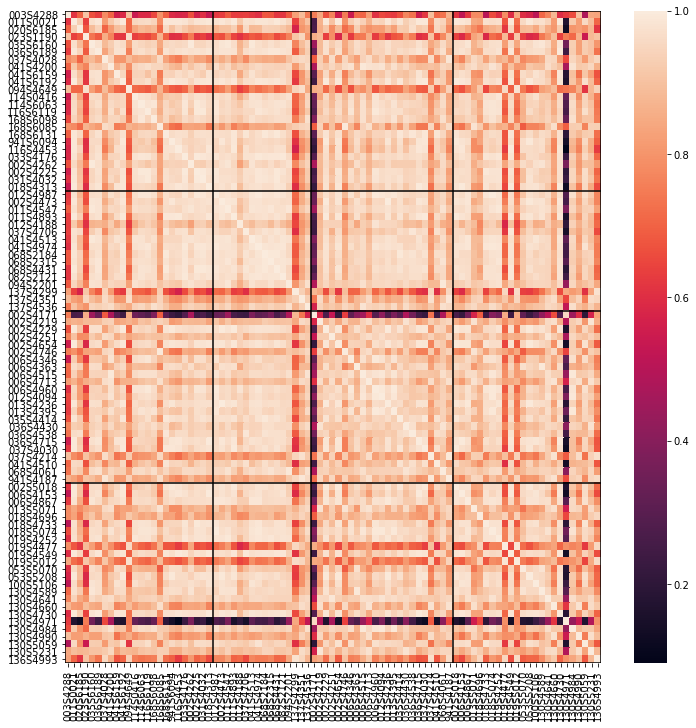

In [21]:
ordered = sub_rel['corr']['loc_36p']['all'][cols]
ordered = ordered.T[cols]
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(ordered,xticklabels=True,yticklabels=True,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

In [22]:
color = []
n = len(subjects_groups)
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [23]:
lut = {}
for i in range(n):
    if i != 0:
        for j in range(sep[i-1],sep[i]):
            lut[cols[j]] = color[i]
    if i == 0:
        for j in range(sep[i]):
            lut[cols[j]] = color[i]
cl = pd.DataFrame(lut, index=[1])

['#21140B', '#A0E9E2', '#269B1A', '#BAC2BE']
['CN', 'EMCI', 'LMCI', 'AD']


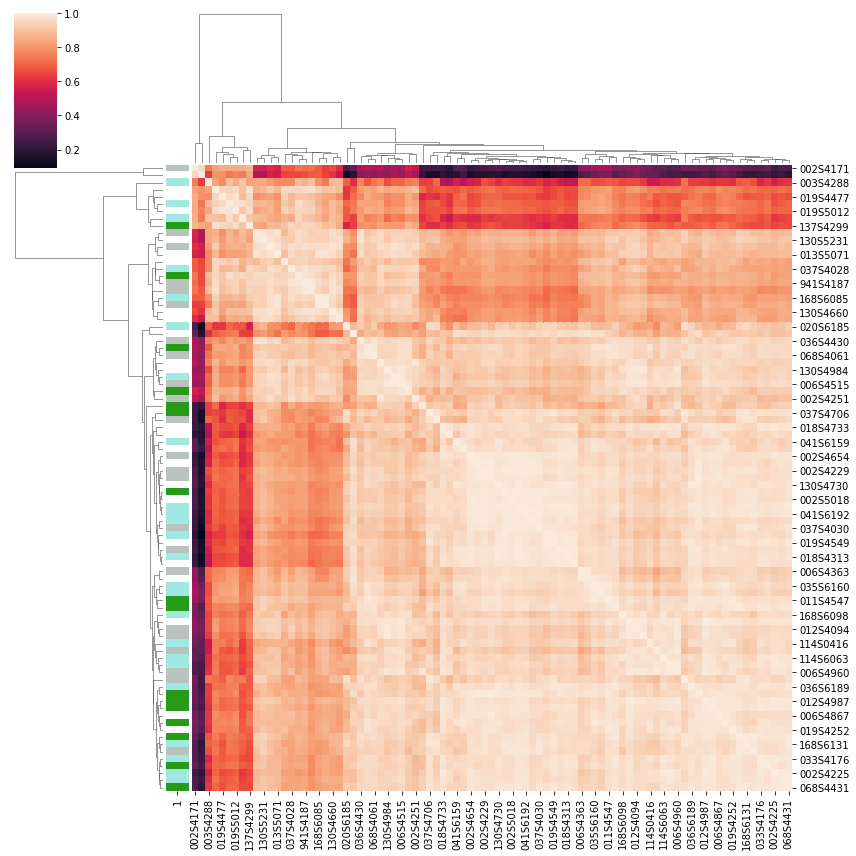

In [24]:
print(color)
print(subjects_groups)
g = sns.clustermap(ordered, row_colors=cl.T,figsize=(12, 12))

#### Correlation based on correlation matrices

In [10]:
subL = []
for i in cols:
    M = gla.read_M(i,ds,ct)
    subL.append(M - np.mean(M))

In [26]:
rv_results = ho.RVcoeff(subL)

sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 40, 63, 87]


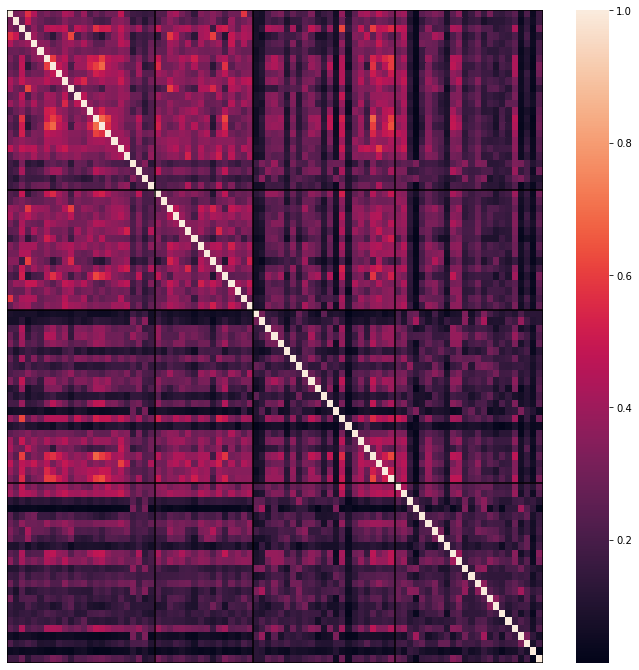

In [27]:
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(rv_results,xticklabels=False,yticklabels=False,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

In [28]:
subLV = [s.reshape((129600,1)) for s in subL]
subC = 0
for i in range(sep[-1]):
    try:
        subC = np.concatenate((subC,subL[i].reshape((1,129600))), axis=0)
    except ValueError:
        subC = subL[i].reshape((1,129600))

sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 40, 63, 87]


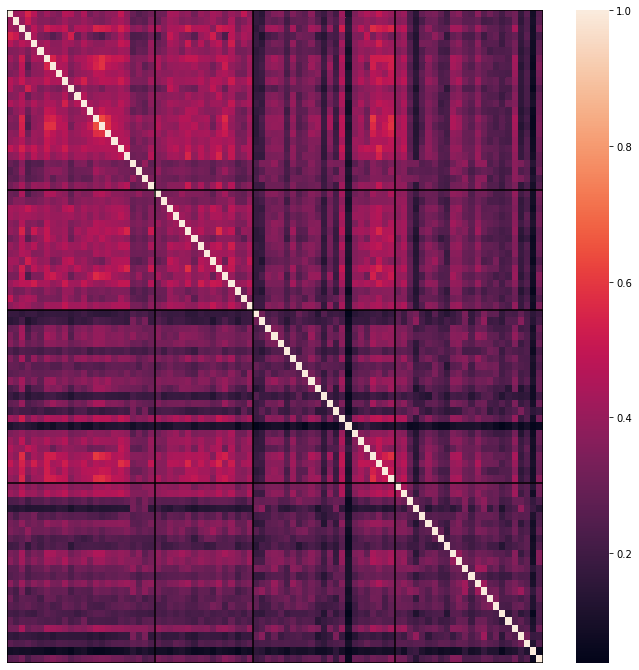

In [29]:
pearsonC = np.corrcoef(subC, y=None, rowvar=True)
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(pearsonC,xticklabels=False,yticklabels=False,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

In [25]:
mantelC = np.zeros((sep[-1], sep[-1]), float)
for i in range(sep[-1]):
    for j in range(i+1,sep[-1]):
        a = subL[i]
        b = subL[j]
        np.fill_diagonal(a, 0)
        np.fill_diagonal(b, 0)
        a = np.round(a, 9)
        b = np.round(b, 9)
        mantelC[i,j] = mantel(a,b)[0]

In [33]:
mantelC = np.where(mantelC,mantelC,mantelC.T)

sections :  ['CN', 'EMCI', 'LMCI', 'AD']
size     :  [0, 24, 40, 63, 87]


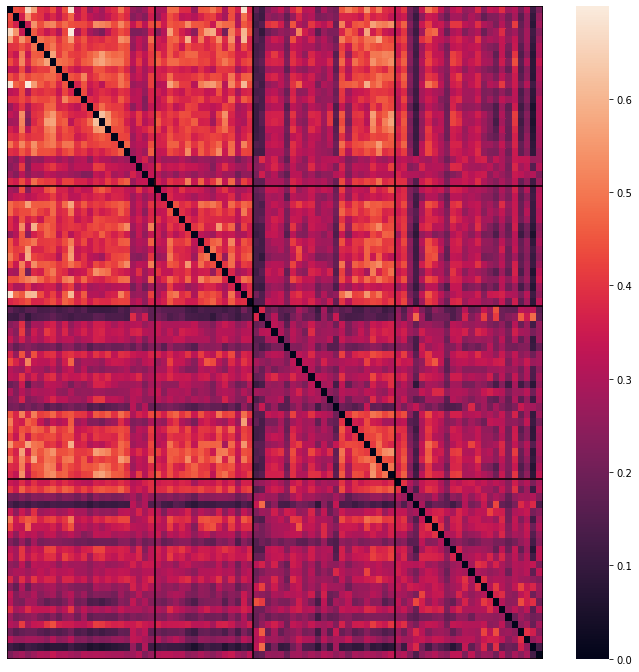

In [103]:
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
ax = sns.heatmap(mantelC,xticklabels=False,yticklabels=False,ax=ax)
ax.hlines(sep, *ax.get_xlim())
ax.vlines(sep, *ax.get_xlim())

print('sections : ',subjects_groups)
print('size     : ',sep)

In [35]:
np.save("%s/data/07_group_level/mantelC"%(rootdir), mantelC)

### Mean Network

Construct the mean network of all subjects from different groups:

In [11]:
meanM = {}
meanG = {}
for g in range(len(subjects_groups)):
    con  = np.dstack(subL[sep[g]:sep[g+1]])
    meanM[subjects_groups[g]] = np.mean(con, axis=2)
    meanG[subjects_groups[g]] = nx.from_numpy_matrix(meanM[subjects_groups[g]])
    nx.write_gexf(meanG[subjects_groups[g]],"%s/data/07_group_level/mean_network/%s_mean_net_ds-%s_corr-%s_tm-%s.gexf"
                  %(rootdir,subjects_groups[g],ds,ct,tm))                    
    np.save("%s/data/07_group_level/mean_network/%s_mean_net_ds-%s_corr-%s_tm-%s"
            %(rootdir,subjects_groups[g],ds,ct,tm), meanM[subjects_groups[g]] )

con = np.dstack(subL[0:sep[-1]])
meanM['all'] = np.mean(con, axis=2)
meanG['all'] = nx.from_numpy_matrix(meanM['all'])
nx.write_gexf(meanG['all'],"%s/data/07_group_level/mean_network/all_subjects_mean_net_ds-%s_corr-%s_tm-%s.gexf"
              %(rootdir,ds,ct,tm))                    
np.save("%s/data/07_group_level/mean_network/all_subjects_mean_net_ds-%s_corr-%s_tm-%s"
        %(rootdir,ds,ct,tm), meanM['all'])

Compute the mean networks centrality measures:

Visualize the mean networks:

In [14]:
from src.viz import viz
dirc = rootdir + "/data/07_group_level/mean_network"
for g in sg:
    path = glob.glob("/%s/*%s*%s*%s*%s*.npy"%(dirc,g,ds,ct,tm))[0]
    title = "Top 0.5%% Edges Of Mean Network Between %s Subjects"%(g)
    viz.brain_viz_from_path(path = path,title=title,density=.005,method='3d',
                            outpath = "%s/viz/3d/%s_mean_net_ds-%s_corr-%s_tm-%s.html"
                            %(dirc,g,ds,ct,tm))

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [16]:
sg = subjects_groups.copy()
sg.append('all')
sg
from src.viz import viz
dirc = rootdir + "/data/07_group_level/mean_network"
for g in sg:
    path = glob.glob("/%s/*%s*%s*%s*%s*.npy"%(dirc,g,ds,ct,tm))[0]
    title = "Top 0.5%% Edges of mean network for %s subjects, ds-%s, corr-%s, tm-%s"%(g ,ds,ct,tm)
    viz.brain_viz_from_path(path = path,title=title,density=.005,method='3d',
                            outpath = "%s/viz/3d/%s_mean_net_ds-%s_corr-%s_tm-%s.html"
                            %(dirc,g,ds,ct,tm))

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casti